In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import joblib

In [2]:
from pandas.core.interchange.dataframe_protocol import Column
# Step 1: Load and preprocess the dataset
data = pd.read_csv('/content/BusVoltage.csv')
data.head()

,Date_time,Voltage
0,1/21/2001 21:00,32.003189
1,1/22/2001 0:00,31.943952
2,1/22/2001 3:00,32.102344
3,1/22/2001 6:00,31.988111
4,1/22/2001 9:00,31.945055


In [3]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data = data.dropna()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46984 entries, 0 to 46983
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date_time  46984 non-null  datetime64[ns]
 1   Voltage    46984 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 734.2 KB


In [5]:
data.describe()

,Voltage
count,46984.000000
mean,33.305102
std,0.993118
min,20.000000
25%,32.539677
50%,33.171442
75%,34.020377
max,35.065620


In [6]:
# Step 2: Feature Engineering (adding more features as needed)
data['hour'] = data['Date_time'].dt.hour
data['day_of_week'] = data['Date_time'].dt.dayofweek

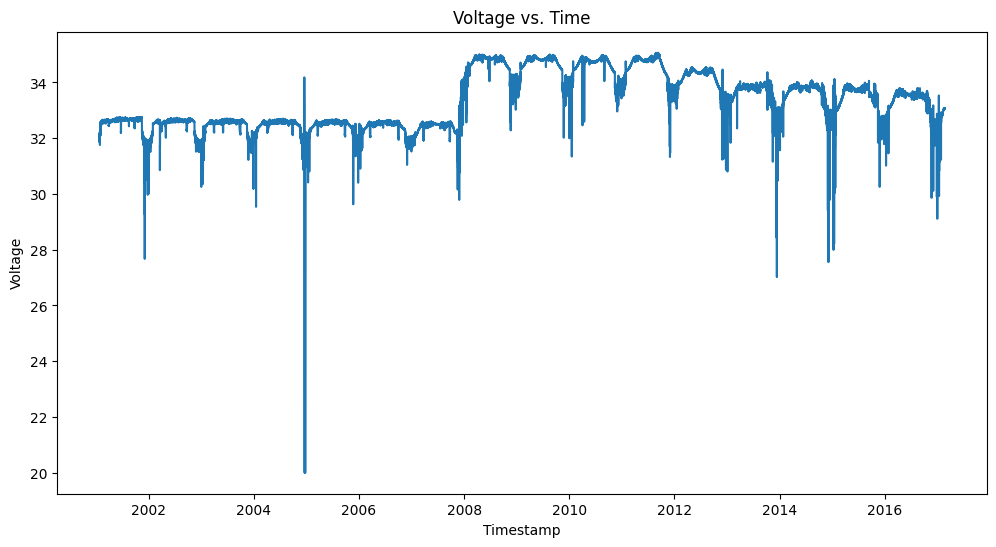

In [7]:
# Step 3: Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['Date_time'], data['Voltage'])
plt.xlabel('Timestamp')
plt.ylabel('Voltage')
plt.title('Voltage vs. Time')
plt.show()

In [9]:
# Step 4: Anomaly Detection with multiple models
def detect_anomalies(data):
    # Initialize arrays to store anomaly scores from different models
    anomaly_scores_if = []
    anomaly_scores_svm = []
    anomaly_scores_lof = []

    # Isolation Forest
    clf_if = IsolationForest(contamination=0.05)
    anomalies_scores_if = clf_if.fit_predict(data[['hour', 'Voltage', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_if = np.where(anomalies_scores_if == 1, 1, -1)

    # One-Class SVM
    clf_svm = OneClassSVM(nu=0.05)
    anomalies_scores_svm = clf_svm.fit_predict(data[['hour', 'Voltage', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_svm = np.where(anomalies_scores_svm == 1, 1, -1)

    # Local Outlier Factor
    clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    anomalies_scores_lof = clf_lof.fit_predict(data[['hour', 'Voltage', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_lof = np.where(anomalies_scores_lof == 1, 1, -1)

    # Stack anomaly scores from different models
    stacked_anomalies = np.column_stack((anomalies_scores_if, anomalies_scores_svm, anomalies_scores_lof))

    # Sum the anomaly scores across models (you can customize the stacking approach)
    final_anomaly_scores = np.sum(stacked_anomalies, axis=1)

    # Define a threshold to identify anomalies
    threshold = np.percentile(final_anomaly_scores, 5)

    # Create a boolean mask for anomalies based on the threshold
    anomalies = final_anomaly_scores > threshold

    return anomalies

# Detect anomalies in the data using multiple models
data['anomaly'] = detect_anomalies(data)
data['anomaly'] = data['anomaly'].astype(int)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



- If a data point is considered normal by the Isolation Forest model, it will be labeled as 1.
- If a data point is considered an anomaly by the Isolation Forest model, it will be labeled as 0

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46984 entries, 0 to 46983
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date_time    46984 non-null  datetime64[ns]
 1   Voltage      46984 non-null  float64       
 2   hour         46984 non-null  int64         
 3   day_of_week  46984 non-null  int64         
 4   anomaly      46984 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.8 MB


In [11]:
data['anomaly'].value_counts()

1    41786
0     5198
Name: anomaly, dtype: int64

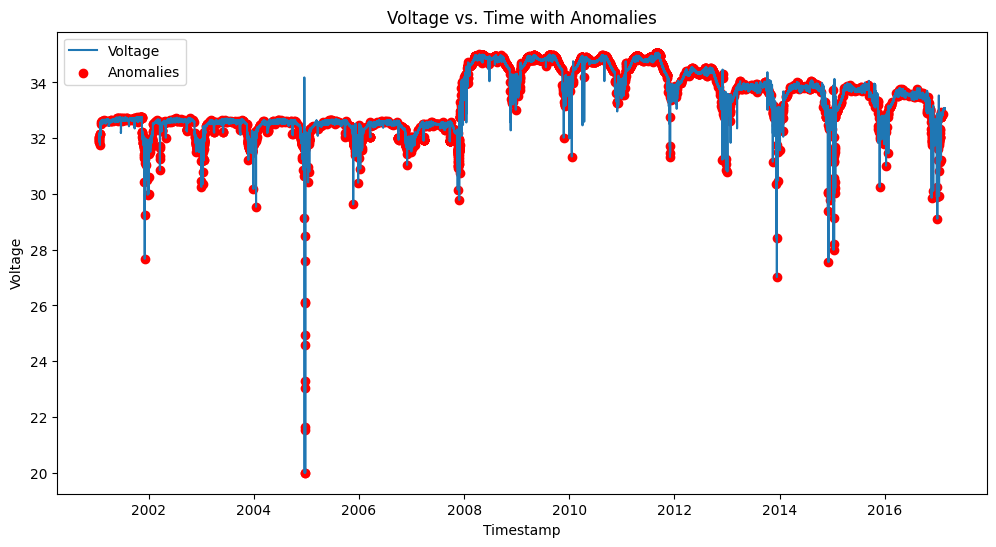

In [12]:
# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['Date_time'], data['Voltage'], label='Voltage')
plt.scatter(data[data['anomaly'] == 0]['Date_time'], data[data['anomaly'] == 0]['Voltage'], c='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Voltage')
plt.title('Voltage vs. Time with Anomalies')
plt.legend()
plt.show()


# Model Building
For building model we have splited the dataset in 9:1  ration 9 parts for training and testing and 1 part for validation.

In [13]:
# Step 5: Model Building
X = data[['hour', 'day_of_week', 'Voltage']]
y = data['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
svm_model = SVC()

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

SVC()

In [15]:
# Make predictions on the validation set
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
svm_pred = svm_model.predict(X_test)

In [16]:
# Stack the predictions from different models
stacked_predictions = [rf_pred, gb_pred, svm_pred]

# Create a VotingClassifier to combine predictions
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('svm', svm_model)
], voting='hard')

In [17]:
# Train the VotingClassifier on the validation set
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier()),
                             ('svm', SVC())])

In [18]:
# Step 6: Model Evaluation
y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9558369692455039
Confusion Matrix:
[[ 632  411]
 [   4 8350]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.61      0.75      1043
           1       0.95      1.00      0.98      8354

    accuracy                           0.96      9397
   macro avg       0.97      0.80      0.86      9397
weighted avg       0.96      0.96      0.95      9397



In [19]:
# Step 7: Predict Anomalies in Validation Data splited from the orignal dataset
# Load and preprocess new data
new_data = pd.read_csv("/content/new_voltage.csv")
new_data['Date_time'] = pd.to_datetime(new_data['Date_time'])
new_data['hour'] = new_data['Date_time'].dt.hour
new_data['day_of_week'] = new_data['Date_time'].dt.dayofweek


In [20]:
# Use the trained model to predict anomalies in new data
new_data['anomaly'] = voting_classifier.predict(new_data[['hour', 'day_of_week', 'Voltage']])

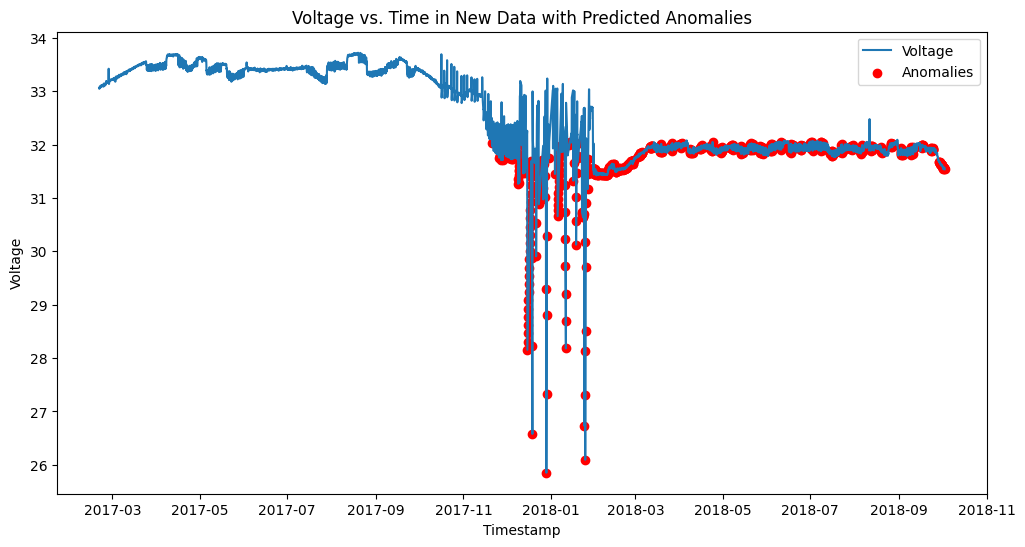

In [22]:
# Visualize anomalies in new data
plt.figure(figsize=(12, 6))
plt.plot(new_data['Date_time'], new_data['Voltage'], label='Voltage')
plt.scatter(new_data[new_data['anomaly'] == 0]['Date_time'], new_data[new_data['anomaly'] == 0]['Voltage'], c='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Voltage')
plt.title('Voltage vs. Time in New Data with Predicted Anomalies')
plt.legend()
plt.show()

In [23]:
#Step# 8 Saving the model
#Save the model
joblib.dump(voting_classifier, "trained_model.pkl")

['trained_model.pkl']

In [24]:
#Step 9: Making the api for web deployment of Model
#Making API for model deployment
from flask import Flask, request, jsonify
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

app = Flask(__name__)

# Load the trained model
model = joblib.load("trained_model.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the POST request
        data = request.get_json(force=True)

        # Preprocess the data (you may need to adjust this based on your preprocessing steps)
        hour = data['hour']
        day_of_week = data['day_of_week']
        voltage = data['voltage']

        # Make predictions using the trained model
        prediction = model.predict([[hour, day_of_week, voltage]])

        # Return the prediction as JSON response
        response = {'prediction': int(prediction[0])}
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
